## Modelo M0 – Espaço sem obstáculos

Aqui consideramos que o espaço livre é homotopicamente trivial $(X \simeq *)$, ou seja, não há restrições globais além da dinâmica e dos limites de controle. O problema se reduz a encontrar uma trajetória dinâmica admissível entre o estado inicial e final.

$$
\begin{aligned}
\text{(M0)} \quad 
\min_{\{x_t,u_t\}_{t=0}^{T-1}} \quad & \sum_{t=0}^{T-1} |u_t|_2^2 \\
\text{sujeito a:} \quad
& x_{t+1} = A x_t + B u_t, \quad t=0,\dots,T-1, \\
& u_{\min} \le u_t \le u_{\max}, \quad t=0,\dots,T-1, \\
& x_0 = x_{\text{start}}, \quad x_T = x_{\text{goal}}.
\end{aligned}
$$

### Comentários

* **Função objetivo:** Minimiza o esforço de controle (ou energia total).
* **Dinâmica:** É um sistema linear discreto controlado.
* **Restrições de controle:** Mantêm o comando dentro de limites físicos.
* **Condições de contorno:** Fixam início e fim da trajetória.
* **Topologia:** Como não há obstáculos, o espaço é contrátil $(\pi_1(X)=0$, $\operatorname{TC}(X)=1)$. Portanto, o problema é puramente convexo e sempre existe solução factível se o sistema for controlável.

Restricted license - for non-production use only - expires 2026-11-23


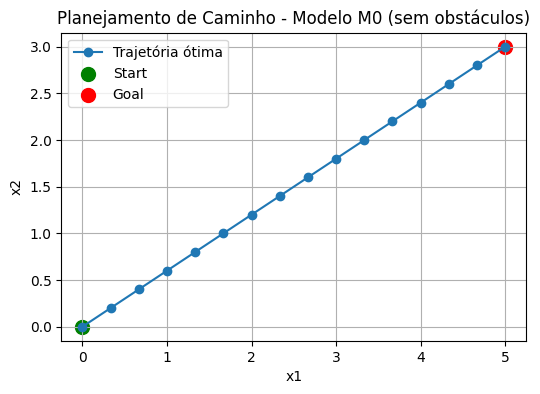

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB

# ---------------------
# PARÂMETROS DO PROBLEMA
# ---------------------
T = 15                   # horizonte de tempo
A = np.eye(2)            # dinâmica identidade
B = np.eye(2)            # controle direto (x_{t+1} = x_t + u_t)
u_min, u_max = -1.0, 1.0 # limites de controle
x_start = np.array([0.0, 0.0])
x_goal  = np.array([5.0, 3.0])

# ---------------------
# MODELO GUROBI
# ---------------------
mdl = Model("M0_PathPlanning")
mdl.setParam('OutputFlag', 0)  # silenciar log

# Variáveis
x = mdl.addVars(T+1, 2, lb=-GRB.INFINITY, name="x")  # estados
u = mdl.addVars(T, 2, lb=u_min, ub=u_max, name="u")  # controles

# Função objetivo: minimizar soma dos quadrados dos controles
mdl.setObjective(sum(u[t,0]*u[t,0] + u[t,1]*u[t,1] for t in range(T)), GRB.MINIMIZE)

# Restrições de dinâmica
for t in range(T):
    mdl.addConstr(x[t+1,0] == A[0,0]*x[t,0] + A[0,1]*x[t,1] + B[0,0]*u[t,0] + B[0,1]*u[t,1])
    mdl.addConstr(x[t+1,1] == A[1,0]*x[t,0] + A[1,1]*x[t,1] + B[1,0]*u[t,0] + B[1,1]*u[t,1])

# Condições de contorno
mdl.addConstr(x[0,0] == x_start[0])
mdl.addConstr(x[0,1] == x_start[1])
mdl.addConstr(x[T,0] == x_goal[0])
mdl.addConstr(x[T,1] == x_goal[1])

# ---------------------
# RESOLUÇÃO
# ---------------------
mdl.optimize()

# Extrair solução
x_sol = np.array([[x[t,0].X, x[t,1].X] for t in range(T+1)])
u_sol = np.array([[u[t,0].X, u[t,1].X] for t in range(T)])

# ---------------------
# PLOTAGEM
# ---------------------
plt.figure(figsize=(6,4))
plt.plot(x_sol[:,0], x_sol[:,1], 'o-', label="Trajetória ótima")
plt.scatter(x_start[0], x_start[1], c='green', s=100, label="Start")
plt.scatter(x_goal[0], x_goal[1], c='red', s=100, label="Goal")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Planejamento de Caminho - Modelo M0 (sem obstáculos)")
plt.legend()
plt.grid(True)
plt.show()


## (M1) Um obstáculo circular — MINLP/SOCP por “evitar segmento–disco”

Considere um obstáculo **disco** $\mathcal{O}={z:|z-c|*2\le r}$ com centro $c\in\mathbb{R}^2$ e raio $r$.
Imponha que **cada segmento** $[x_t,x*{t+1}]$ fique a pelo menos $r$ do centro $c$.
Uma maneira contínua/convexa é garantir que o **ponto mais próximo** do segmento ao centro tenha distância $\ge r$.
Introduza variáveis auxiliares $\lambda_t\in[0,1]$ e $y_t$ como o ponto do segmento mais próximo de $c$:

$$
\begin{aligned}
\min_{\substack{\{x_t,u_t\}\\ \{\lambda_t,y_t\}}}\quad
& \sum_{t=0}^{T-1}|u_t|_2^2 \\
\text{s.a.}\quad
& x_{t+1}=Ax_t+Bu_t,\quad t=0,\dots,T-1,\\
& u_{\min}\le u_t\le u_{\max},\quad t=0,\dots,T-1,\\
& x_0=x_{\text{start}},\quad x_T=x_{\text{goal}},\\
& y_t = (1-\lambda_t),x_t + \lambda_t,x_{t+1},\quad t=0,\dots,T-1,\\
& 0\le \lambda_t \le 1,\quad t=0,\dots,T-1,\\
& |y_t - c|_2 ;\ge; r,\quad t=0,\dots,T-1.
\end{aligned}
$$

* As últimas três linhas dizem: **escolha o ponto do segmento** $[x_t,x_{t+1}]$ mais “crítico” (via $\lambda_t$) e **afaste-o** do centro ao menos $r$.
* As restrições são **convexas** (SOCP) exceto pela escolha “exata” do ponto mais próximo. Na prática, esse modelo funciona como **relaxação segura**: se $|y_t-c|\ge r$ para algum $y_t$ **livre** em $[x_t,x_{t+1}]$, então o segmento inteiro está fora do disco *não necessariamente*; para tornar **exato**, adiciona-se condições KKT do problema interno (vira MINLP).
* Alternativa **disjuntiva (MIQP)**: escolha “passar à esquerda/direita” de uma **reta de suporte** ao disco (duas meia-planos), usando binárias e Big-M (ver (M2)).


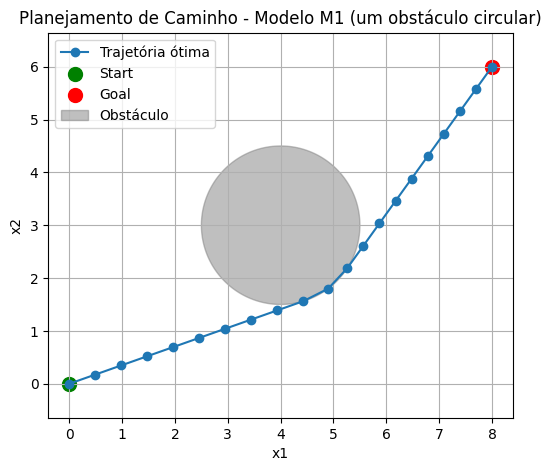

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, QuadExpr

# ---------------------
# PARÂMETROS
# ---------------------
T = 20                     # horizonte
u_min, u_max = -1.0, 1.0   # limites de controle
x_start = np.array([0.0, 0.0])
x_goal  = np.array([8.0, 6.0])

# Obstáculo circular
c = np.array([4.0, 3.0])   # centro
r = 1.5                    # raio

# ---------------------
# MODELO GUROBI
# ---------------------
mdl = Model("M1_PathPlanning")
mdl.setParam('OutputFlag', 0)

# Variáveis
x = mdl.addVars(T+1, 2, lb=-GRB.INFINITY, name="x")   # estados
u = mdl.addVars(T, 2, lb=u_min, ub=u_max, name="u")   # controles

# Objetivo: minimizar energia de controle
mdl.setObjective(sum(u[t,0]*u[t,0] + u[t,1]*u[t,1] for t in range(T)), GRB.MINIMIZE)

# Dinâmica: x_{t+1} = x_t + u_t
for t in range(T):
    mdl.addConstr(x[t+1,0] == x[t,0] + u[t,0])
    mdl.addConstr(x[t+1,1] == x[t,1] + u[t,1])

# Condições de contorno
mdl.addConstr(x[0,0] == x_start[0])
mdl.addConstr(x[0,1] == x_start[1])
mdl.addConstr(x[T,0] == x_goal[0])
mdl.addConstr(x[T,1] == x_goal[1])

# Restrição de não colisão (cada ponto fora do círculo)
for t in range(T+1):
    expr = QuadExpr()
    expr.add((x[t,0] - c[0]) * (x[t,0] - c[0]))
    expr.add((x[t,1] - c[1]) * (x[t,1] - c[1]))
    mdl.addQConstr(expr >= r*r)

# ---------------------
# RESOLUÇÃO
# ---------------------
mdl.optimize()

# Extrair solução
x_sol = np.array([[x[t,0].X, x[t,1].X] for t in range(T+1)])

# ---------------------
# PLOTAGEM
# ---------------------
theta = np.linspace(0, 2*np.pi, 200)
circle_x = c[0] + r*np.cos(theta)
circle_y = c[1] + r*np.sin(theta)

plt.figure(figsize=(6,5))
plt.plot(x_sol[:,0], x_sol[:,1], 'o-', label="Trajetória ótima")
plt.scatter(x_start[0], x_start[1], c='green', s=100, label="Start")
plt.scatter(x_goal[0], x_goal[1], c='red', s=100, label="Goal")
plt.fill(circle_x, circle_y, color='gray', alpha=0.5, label="Obstáculo")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Planejamento de Caminho - Modelo M1 (um obstáculo circular)")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()


## (M2) (N) obstáculos poligonais — MILP/MIQP disjuntivo por meia-planos (homotopia explícita)

Para cada obstáculo $i=1,\dots,N$, fixe um **conjunto finito de meia-planos seguros** que “envolvem” o obstáculo inflado (por exemplo, as retas tangentes à circunferência ou as arestas do casco de um polígono expandido).
Denote por $\mathcal{H}*i={(h*{i,k},g_{i,k})}*{k=1}^{K_i}$ as normais/limiares dos meia-planos $h*{i,k}^\top z \le g_{i,k}$ que **delimitam a região proibida**.
Para cada **segmento** $t$ e **obstáculo** $i$, impomos que o segmento esteja **inteiramente** de **um lado seguro** de **pelo menos uma** dessas retas (passar “por cima/baixo/esquerda/direita”). Isso é uma **disjunção** modelada com binárias.

Variáveis:

* $x_t,u_t$ como antes.
* Binárias $b_{i,k,t}\in{0,1}$ escolhendo **qual meia-plano** evita o obstáculo $i$ no segmento $t$.
* Constante grande $M>0$ e margem $\epsilon>0$.

Modelo:

$$
\begin{aligned}
\min \quad & \sum_{t=0}^{T-1}|u_t|_2^2 \\
\text{s.a.}\quad
& x_{t+1}=Ax_t+Bu_t,\quad t=0,\dots,T-1,\\
& u_{\min}\le u_t\le u_{\max},\quad t=0,\dots,T-1,\\
& x_0=x_{\text{start}},\quad x_T=x_{\text{goal}},\\
& \sum_{k=1}^{K_i} b_{i,k,t} ;\ge; 1,\quad \forall i,; t, \qquad\text{(escolhe ao menos um lado seguro)}\\
& h_{i,k}^\top x_t ;\ge; g_{i,k} + \epsilon - M(1-b_{i,k,t}),\quad \forall i,k,t,\\
& h_{i,k}^\top x_{t+1} ;\ge; g_{i,k} + \epsilon - M(1-b_{i,k,t}),\quad \forall i,k,t,\\
& b_{i,k,t}\in{0,1}.
\end{aligned}
$$

Interpretação:

* Se (b_{i,k,t}=1), **ambos** (x_t) e (x_{t+1}) ficam no lado seguro do meia-plano (k) relativo ao obstáculo (i) (o segmento inteiro também fica, por convexidade do meia-plano).
* A soma (\sum_k b_{i,k,t}\ge 1) força **ao menos uma** escolha por obstáculo/segmento.
* Escolhendo apropriadamente (\mathcal{H}_i) (ex.: quatro tangentes cardinais do disco inflado ou as normais das arestas de um polígono), você obtém um conjunto de **corredores homotópicos**; as variáveis binárias **codificam a classe de homotopia** ao longo do horizonte.
* O problema é um **MILP/MIQP** (linear se custo L1, MIQP com custo L2).

> Observações práticas
> • Para discos, um conjunto pequeno de tangentes já cria opções “esquerda/direita/cima/baixo”.
> • Pode-se “encadear” a homotopia exigindo consistência temporal: por obstáculo (i), limitar trocas de (k) ao longo de (t) (adicionando custos/penalidades de troca ou restrições (b_{i,k,t}-b_{i,k,t-1})).
> • Para poligonais, usar diretamente as **arestas externas** do obstáculo expandido como meia-planos de exclusão.


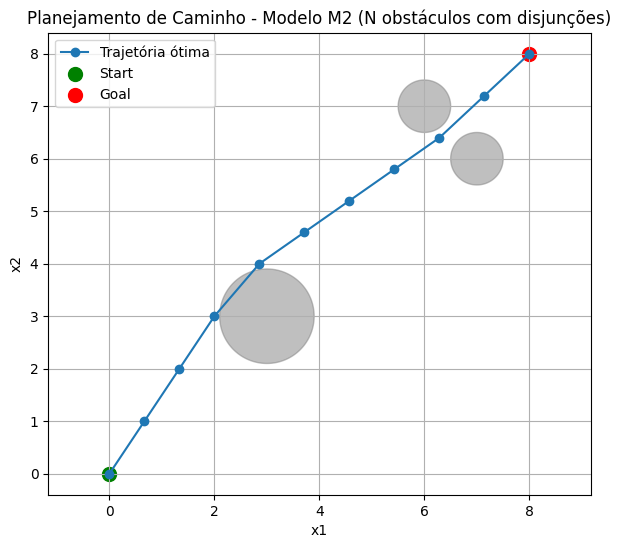

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB

# ---------------------
# PARÂMETROS
# ---------------------
T = 10
u_min, u_max = -1.0, 1.0
x_start = np.array([0.0, 0.0])
x_goal  = np.array([8.0, 8.0])

# Lista de obstáculos (círculos)
obstacles = [
    (np.array([3.0, 3.0]), 0.9),
    (np.array([7.0, 6.0]), 0.5),
    (np.array([6.0, 7.0]), 0.5),
]

epsilon = 0.1
M = 100.0

# ---------------------
# MODELO GUROBI
# ---------------------
mdl = Model("M2_PathPlanning")
mdl.setParam('OutputFlag', 0)

# Variáveis
x = mdl.addVars(T+1, 2, lb=-GRB.INFINITY, name="x")
u = mdl.addVars(T, 2, lb=u_min, ub=u_max, name="u")

# Binárias: para cada obstáculo i, tempo t e direção (L,R,B,T)
b = {}
for i in range(len(obstacles)):
    for t in range(T+1):
        for d in ["L", "R", "B", "T"]:
            b[i,t,d] = mdl.addVar(vtype=GRB.BINARY, name=f"b_{i}_{t}_{d}")

mdl.update()

# Objetivo: minimizar energia de controle
mdl.setObjective(sum(u[t,0]*u[t,0] + u[t,1]*u[t,1] for t in range(T)), GRB.MINIMIZE)

# Dinâmica
for t in range(T):
    mdl.addConstr(x[t+1,0] == x[t,0] + u[t,0])
    mdl.addConstr(x[t+1,1] == x[t,1] + u[t,1])

# Condições de contorno
mdl.addConstr(x[0,0] == x_start[0])
mdl.addConstr(x[0,1] == x_start[1])
mdl.addConstr(x[T,0] == x_goal[0])
mdl.addConstr(x[T,1] == x_goal[1])

# Restrições de não colisão disjuntivas
for i,(c,r) in enumerate(obstacles):
    for t in range(T+1):
        # Cada ponto deve satisfazer ao menos uma das 4 opções
        mdl.addConstr(b[i,t,"L"] + b[i,t,"R"] + b[i,t,"B"] + b[i,t,"T"] >= 1)

        # Esquerda
        mdl.addConstr(x[t,0] <= c[0] - r - epsilon + M*(1-b[i,t,"L"]))
        # Direita
        mdl.addConstr(x[t,0] >= c[0] + r + epsilon - M*(1-b[i,t,"R"]))
        # Abaixo
        mdl.addConstr(x[t,1] <= c[1] - r - epsilon + M*(1-b[i,t,"B"]))
        # Acima
        mdl.addConstr(x[t,1] >= c[1] + r + epsilon - M*(1-b[i,t,"T"]))

# ---------------------
# RESOLUÇÃO
# ---------------------
mdl.optimize()

# Extrair solução
x_sol = np.array([[x[t,0].X, x[t,1].X] for t in range(T+1)])

# ---------------------
# PLOTAGEM
# ---------------------
plt.figure(figsize=(7,6))
plt.plot(x_sol[:,0], x_sol[:,1], 'o-', label="Trajetória ótima")
plt.scatter(x_start[0], x_start[1], c='green', s=100, label="Start")
plt.scatter(x_goal[0], x_goal[1], c='red', s=100, label="Goal")

theta = np.linspace(0,2*np.pi,200)
for (c,r) in obstacles:
    plt.fill(c[0] + r*np.cos(theta), c[1] + r*np.sin(theta), color='gray', alpha=0.5)

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Planejamento de Caminho - Modelo M2 (N obstáculos com disjunções)")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()
